In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd

import lightgbm as lgb
from lightgbm import LGBMClassifier

In [3]:
from scipy.stats import kruskal
from statannot import add_stat_annotation

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
sns.set_theme()
sns.set_palette("tab10")
font_name = "Heiti TC"
mpl.rcParams['font.family']=font_name
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.labelsize'] = 13

我们的影响因子有：

1. 任务类型
2. 广告优劣顺序
3. 广告位置
4. 广告形式
5. 广告质量

测定的指标为

- 总注视时长 Total fixation duration

### 读取数据

In [6]:
table_file = "data/第6组-探究偏差：搜索结果页中广告对眼动的影响研究.xlsx"
data = pd.read_excel(table_file)

In [7]:
data

,total fixation duration,fixation count,time to first fixation,fixation rate,广告质量,任务类型,优劣顺序,任务内容,位置,形式,广告质量（细分）
0,1.05,8,-,0.103858,1,1,1,1,1,5,5
1,0.00,0,0.77,0.000000,1,1,1,1,2,1,1
2,0.00,0,3.39,0.000000,1,1,1,1,3,1,1
3,0.31,2,4.26,0.030663,1,1,1,1,4,2,1
4,1.42,9,-,0.140455,1,1,1,1,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...
11292,2.82,12,8.3,0.102285,2,2,3,18,7,3,4
11293,4.79,15,3.53,0.170710,2,2,3,18,8,3,4
11294,6.32,28,4.42,0.229205,2,2,3,18,9,4,4
11295,1.27,7,5.05,0.046065,2,2,3,18,10,3,4


In [8]:
table_file = "data/第6组-探究偏差：搜索结果页中广告对眼动的影响研究.xlsx"
data = pd.read_excel(table_file)
data = data[['total fixation duration ', '任务类型', '优劣顺序', '位置', '形式', '广告质量', '广告质量（细分）']]
data.columns = ['y', 'task_type', 'ad_order', 'ad_pos', 'ad_form', 'ad_quality', 'ad_quality_detailed']
data['total'] = data['y']

In [9]:
data

,y,task_type,ad_order,ad_pos,ad_form,ad_quality,ad_quality_detailed,total
0,1.05,1,1,1,5,1,5,1.05
1,0.00,1,1,2,1,1,1,0.00
2,0.00,1,1,3,1,1,1,0.00
3,0.31,1,1,4,2,1,1,0.31
4,1.42,1,1,5,2,1,1,1.42
...,...,...,...,...,...,...,...,...
11292,2.82,2,3,7,3,2,4,2.82
11293,4.79,2,3,8,3,2,4,4.79
11294,6.32,2,3,9,4,2,4,6.32
11295,1.27,2,3,10,3,2,4,1.27


我们需要计算相对注视影响，即为注视该模块的用时在整个页面中的占比

Here we compute the relative fixation impact, which is the porpotiona of fixation duration for each block in the whole page.

In [10]:
cutter = np.arange(0, len(data), 11)
new_y = []
combs = []
total_data = None
for ix, n in enumerate(cutter):
    if ix < len(cutter) - 1:
        subdata = data.iloc[range(n, cutter[ix+1]), :].copy()
        assert subdata['ad_pos'].tolist() == list(range(1, 12))
        total_time = subdata.sum()['y']
        subdata['y'] = subdata['y'] / total_time
        if total_data is None:
            total_data = subdata
        else:
            total_data = pd.concat([total_data, subdata])
total_data = total_data.reset_index(drop=True) # transform y in to relative fixation impact
ad_data = total_data[total_data['ad_pos'].isin([1,2,3,4,5])] # select only ad blocks

In [11]:
search_result = total_data[total_data['ad_pos'].isin([6,  7,  8,  9, 10, 11])]

### 统计计算说明

以下所有的单因素分析中，多组间差异分析采用**Kruskal-Wallis**测试，用于判定是否存在组间差异

两两比较使用**Bonferroni矫正**后的双尾**Mann-Whitney-Wilcoxon**测试

图片中关于p值的标记说明
- ns: 5.00e-02 < p <= 1.00e+00
- \*: 1.00e-02 < p <= 5.00e-02
- \*\*: 1.00e-03 < p <= 1.00e-02
- \*\*\*: 1.00e-04 < p <= 1.00e-03
- \*\*\*\*: p <= 1.00e-04

In [12]:
ylabel="相对注视时长"

In [15]:
def compare_groups(data, factor, groups):
    s, p = kruskal(*[data[data[factor] == i]['y'] for i in groups])
    print(f"The difference among {len(groups)} groups exists, H-value: {s}, pvalue: {p}")   
    
def plot_kw(data, factor, groups):
    return dict(data=data[data[factor].isin(groups)], x=factor, y='y')
    
stat_anno_kw = dict(
                    test='Mann-Whitney',
                    text_format='star',
                    loc='outside',
                    verbose=2
                   )

### 任务类型

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.674e-02 U_stat=1.546e+07


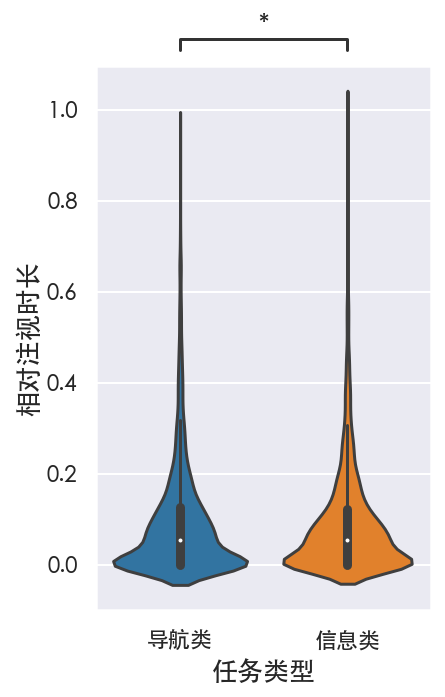

In [20]:
kw = plot_kw(total_data, 'task_type', [1, 2])
fig, ax = plt.subplots(figsize=(3, 5))
ax = sns.violinplot(**kw, ax=ax)
test_results = add_stat_annotation(ax, 
                                   **kw, 
                                   **stat_anno_kw,
                                   box_pairs=[(1, 2)],
                                  )
_ = ax.set(
    xlabel="任务类型",
    ylabel=ylabel,
    xticklabels=["导航类", "信息类"],
)

In [21]:
total_data.groupby('task_type').mean()

,y,ad_order,ad_pos,ad_form,ad_quality,ad_quality_detailed,total
task_type,,,,,,,
1,0.090952,2.030992,6.0,2.832645,1.502066,2.910969,0.562496
2,0.090870,1.974170,6.0,2.833781,1.496310,2.905736,0.748428


只看广告数据

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.655e-01 U_stat=3.209e+06


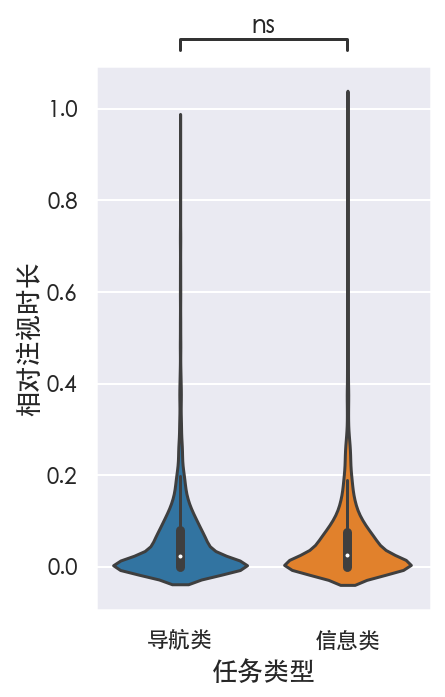

In [22]:
kw = plot_kw(ad_data, 'task_type', [1, 2])
fig, ax = plt.subplots(figsize=(3, 5))
ax = sns.violinplot(**kw, ax=ax)
test_results = add_stat_annotation(ax, 
                                   **kw, 
                                   **stat_anno_kw,
                                   box_pairs=[(1, 2)],
                                  )
_ = ax.set(
    xlabel="任务类型",
    ylabel=ylabel,
    xticklabels=["导航类", "信息类"],
)

### 广告位置

In [15]:
compare_groups(total_data, 'ad_pos', [1,2,3,4,5,6,7,8,9,10,11])

The difference among 11 groups exists, H-value: 2160.0490589096057, pvalue: 0.0


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.081e-73 U_stat=3.066e+05
3 v.s. 4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.175e-30 U_stat=3.724e+05
4 v.s. 5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.891e-57 U_stat=7.379e+05
5 v.s. 6: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.681e-111 U_stat=2.287e+05
5 v.s. 11: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.993e-06 U_stat=4.611e+05
4 v.s. 11: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.767e-17 U_stat=6.397e+05


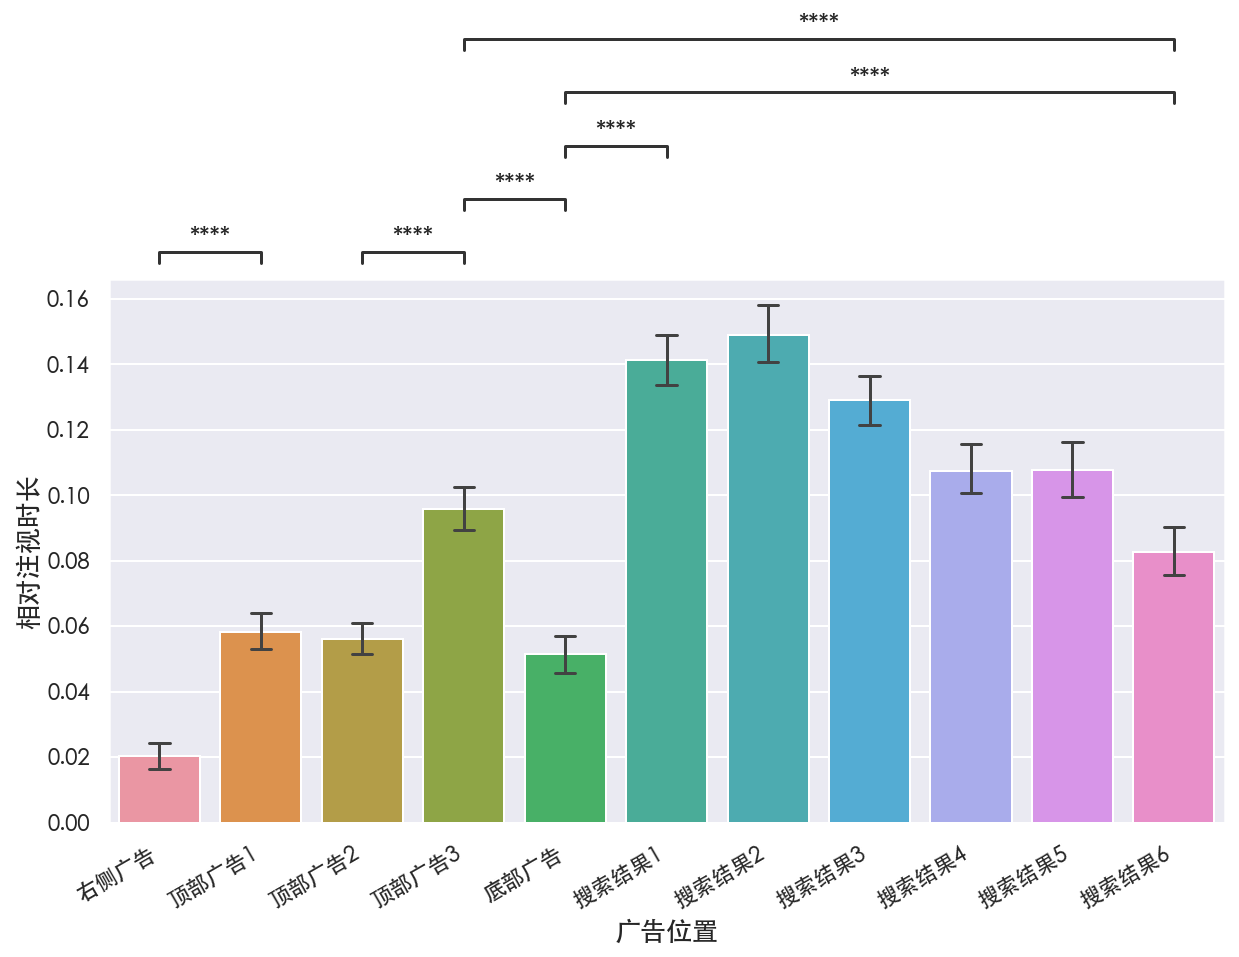

In [56]:
kw = plot_kw(total_data, 'ad_pos', [1,2,3,4,5,6,7,8,9,10,11])
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(**kw, ax=ax, capsize=.2, errwidth=1.5)
test_results = add_stat_annotation(ax,
                                   **kw, 
                                   **stat_anno_kw,
                                   box_pairs=[(1, 2), (3, 4), (4, 5), (5, 6), (4, 11), (5, 11)]
                                  )

ad_pos_label = ["右侧广告", "顶部广告1", "顶部广告2", "顶部广告3", "底部广告",
                "搜索结果1", "搜索结果2", "搜索结果3", "搜索结果4", "搜索结果5", "搜索结果6"]
_ = ax.set(
    ylabel=ylabel,
    xlabel="广告位置",
    xticklabels=ad_pos_label,
)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

10_1 v.s. 10_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.829e-07 U_stat=1.056e+05
11_1 v.s. 11_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.339e+05
9_1 v.s. 9_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.032e-05 U_stat=1.100e+05
2_1 v.s. 2_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.151e-04 U_stat=1.502e+05
1_1 v.s. 1_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.368e+05
3_1 v.s. 3_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.978e-04 U_stat=1.498e+05
4_1 v.s. 4_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.227e-08 U_stat=1.600e+05
5_1 v.s. 5_2: Mann-Whitney-Wilcoxon test two-sid

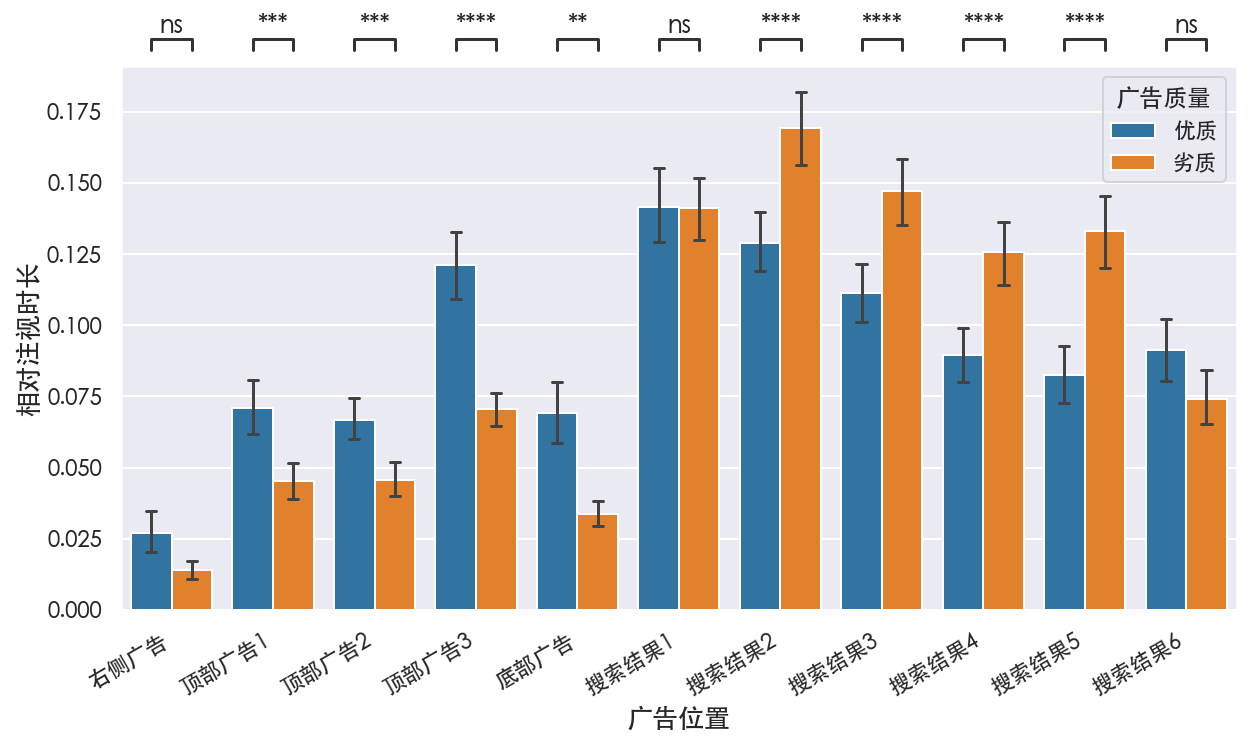

In [34]:
kw = dict(data=total_data, x='ad_pos', y='y')
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(**kw, hue="ad_quality", ax=ax, capsize=.1, errwidth=1.5)

test_results = add_stat_annotation(ax,
                                   hue="ad_quality",
                                   **kw, 
                                   **stat_anno_kw,
                                   box_pairs=[((i,1), (i,2)) for i in range(1, 12)]
                                  )

leg = ax.get_legend()
leg.set_title("广告质量")
for l, t in zip(leg.texts, ["优质", "劣质"]):
    l.set_text(t)

_ = ax.set(
    ylabel=ylabel,
    xlabel="广告位置",
    xticklabels=ad_pos_label
)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

10_1 v.s. 10_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.295e+05
11_1 v.s. 11_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.129e-05 U_stat=1.099e+05
9_1 v.s. 9_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.117e-08 U_stat=1.038e+05
2_1 v.s. 2_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.251e+05
1_1 v.s. 1_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.324e+05
3_1 v.s. 3_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.309e+05
4_1 v.s. 4_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.328e+05
5_1 v.s. 5_2: Mann-Whitney-Wilcoxon test two-sid

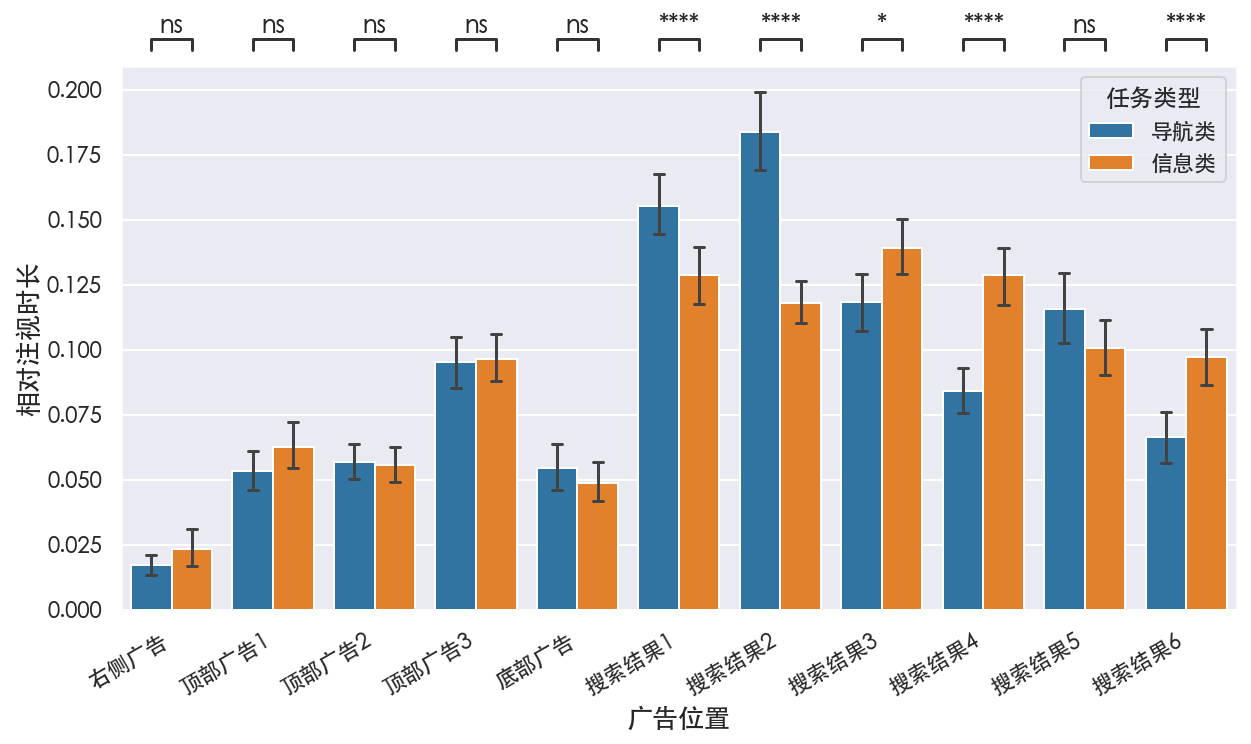

In [35]:
kw = dict(data=total_data, x='ad_pos', y='y')
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(**kw, hue="task_type", ax=ax, capsize=.1, errwidth=1.5)

test_results = add_stat_annotation(ax,
                                   hue="task_type",
                                   **kw, 
                                   **stat_anno_kw,
                                   box_pairs=[((i,1), (i,2)) for i in range(1, 12)]
                                  )

leg = ax.get_legend()
leg.set_title("任务类型")
for l, t in zip(leg.texts, ["导航类", "信息类"]):
    l.set_text(t)

_ = ax.set(
    ylabel=ylabel,
    xlabel="广告位置",
    xticklabels=ad_pos_label
)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

10_1 v.s. 10_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.829e-07 U_stat=1.056e+05
11_1 v.s. 11_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.339e+05
9_1 v.s. 9_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.032e-05 U_stat=1.100e+05
2_1 v.s. 2_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.151e-04 U_stat=1.502e+05
1_1 v.s. 1_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.368e+05
3_1 v.s. 3_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.978e-04 U_stat=1.498e+05
4_1 v.s. 4_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.227e-08 U_stat=1.600e+05
5_1 v.s. 5_2: Mann-Whitney-Wilcoxon test two-sid

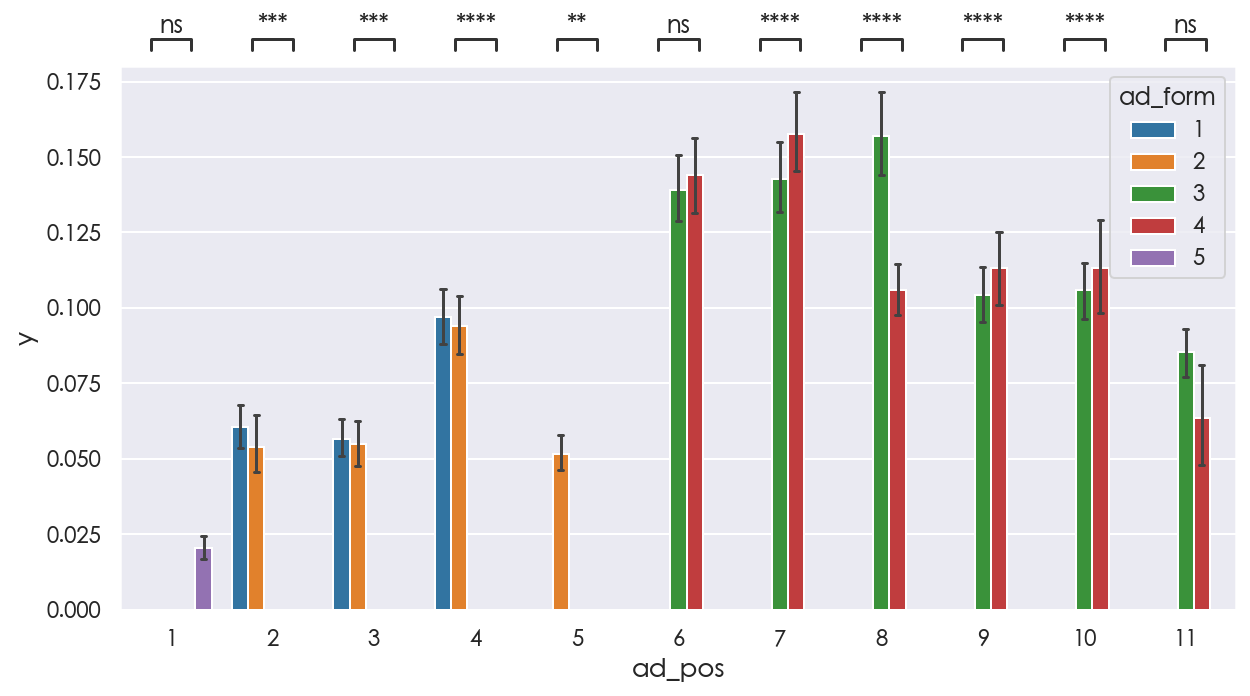

In [37]:
kw = dict(data=total_data, x='ad_pos', y='y')
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(**kw, hue="ad_form", ax=ax, capsize=.05, errwidth=1.5)

test_results = add_stat_annotation(ax,
                                   hue="ad_quality",
                                   **kw, 
                                   **stat_anno_kw,
                                   box_pairs=[((i,1), (i,2)) for i in range(1, 12)]
                                  )

### 广告形式

In [19]:
compare_groups(total_data, 'ad_form', [1,2,3,4,5])

The difference among 5 groups exists, H-value: 1511.4441212568502, pvalue: 0.0


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.466e-06 U_stat=2.286e+06
2 v.s. 5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.907e-90 U_stat=1.489e+06


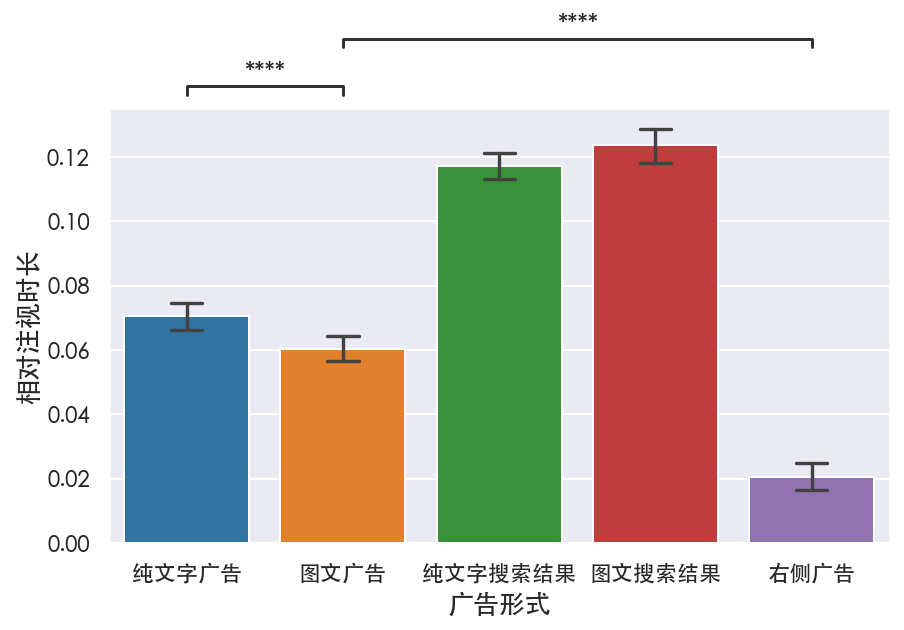

In [46]:
kw = plot_kw(total_data, 'ad_form', [1,2,3,4,5])
fig, ax = plt.subplots(figsize=(7, 4))
ax = sns.barplot(**kw, ax=ax, capsize=.2, errwidth=1.7)
test_results = add_stat_annotation(ax, 
                                   **kw,
                                   **stat_anno_kw,
                                   box_pairs=[(1, 2), (2, 5)],
                                  )
_ = ax.set(
    ylabel=ylabel,
    xlabel="广告形式",
    xticklabels=["纯文字广告", "图文广告", "纯文字搜索结果", "图文搜索结果", "右侧广告"]
)

### 广告质量

广告质量在单个页面中是不变的，只在不同页面中变化

因此我们将每个页面中的广告时间合并，对不同页面进行比较

In [54]:
cutter = np.arange(0, len(data), 11)


records = []
for ix, n in enumerate(cutter):
    if ix < len(cutter) - 1:
        subdata = data.iloc[range(n, cutter[ix+1]), :].copy()
        assert subdata['ad_pos'].tolist() == list(range(1, 12))
        page_ad_total = subdata.iloc[range(0, 5), :].sum()['y']
        total_time = subdata.sum()['y']
        ad_relative_view = page_ad_total / total_time
        records.append([ad_relative_view, subdata['ad_quality'].unique()[0], subdata['ad_order'].unique()[0]])

quality_sum = pd.DataFrame(data=records, columns=['y', 'ad_quality', 'ad_order'])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.860e-33 U_stat=1.884e+05


Text(0.5, 1.03, '所有广告AOI')

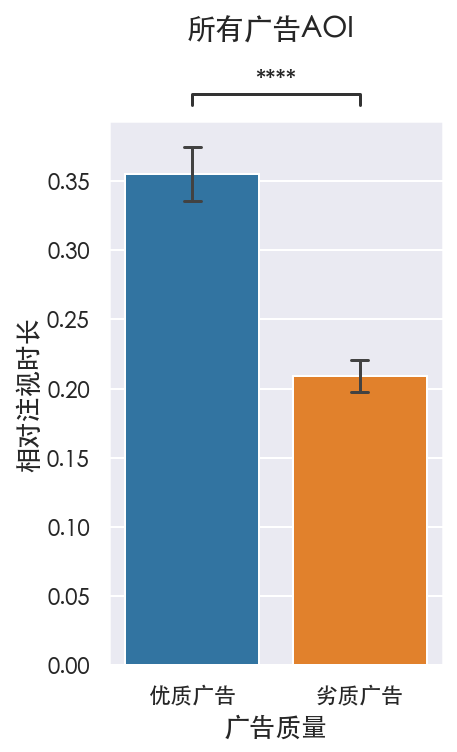

In [45]:
kw = plot_kw(quality_sum, 'ad_quality', [1,2])
fig, ax = plt.subplots(figsize=(3, 5))
ax = sns.barplot(**kw, ax=ax, capsize=.1, errwidth=1.5)
test_results = add_stat_annotation(ax, 
                                   **kw,
                                   **stat_anno_kw,
                                   box_pairs=[(1, 2)],
                                  )
_ = ax.set(
    ylabel=ylabel,
    xlabel="广告质量",
    xticklabels=["优质广告", "劣质广告"]
)

plt.suptitle("所有广告AOI", y=1.03)

In [47]:
cutter = np.arange(0, len(data), 11)


records = []
for ix, n in enumerate(cutter):
    if ix < len(cutter) - 1:
        subdata = data.iloc[range(n, cutter[ix+1]), :].copy()
        assert subdata['ad_pos'].tolist() == list(range(1, 12))
        page_sr_total = subdata.iloc[range(5, 11), :].sum()['y']
        total_time = subdata.sum()['y']
        sr_relative_view = page_sr_total / total_time
        records.append([sr_relative_view, subdata['ad_quality'].unique()[0], subdata['ad_order'].unique()[0]])

quality_sum = pd.DataFrame(data=records, columns=['y', 'ad_quality', 'ad_order'])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.897e-33 U_stat=7.476e+04


Text(0.5, 1.03, '所有搜索结果AOI')

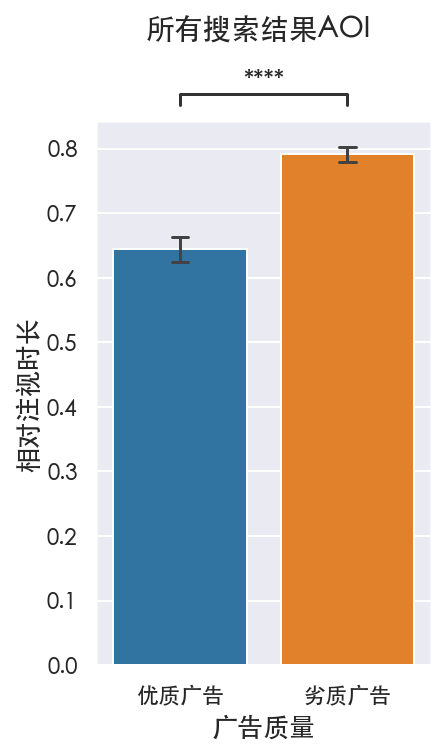

In [48]:
kw = plot_kw(quality_sum, 'ad_quality', [1,2])
fig, ax = plt.subplots(figsize=(3, 5))
ax = sns.barplot(**kw, ax=ax, capsize=.1, errwidth=1.5)
test_results = add_stat_annotation(ax, 
                                   **kw,
                                   **stat_anno_kw,
                                   box_pairs=[(1, 2)],
                                  )
_ = ax.set(
    ylabel=ylabel,
    xlabel="广告质量",
    xticklabels=["优质广告", "劣质广告"]
)

plt.suptitle("所有搜索结果AOI", y=1.03)

In [49]:
cutter = np.arange(0, len(data), 11)


records = []
for ix, n in enumerate(cutter):
    if ix < len(cutter) - 1:
        subdata = data.iloc[range(n, cutter[ix+1]), :].copy()
        assert subdata['ad_pos'].tolist() == list(range(1, 12))
        page_sr_total = subdata.iloc[0, :]['y']
        total_time = subdata.sum()['y']
        sr_relative_view = page_sr_total / total_time
        records.append([sr_relative_view, subdata['ad_quality'].unique()[0], subdata['ad_order'].unique()[0]])

quality_sum = pd.DataFrame(data=records, columns=['y', 'ad_quality', 'ad_order'])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.365e-01 U_stat=1.368e+05


Text(0.5, 1.03, '右侧广告AOI')

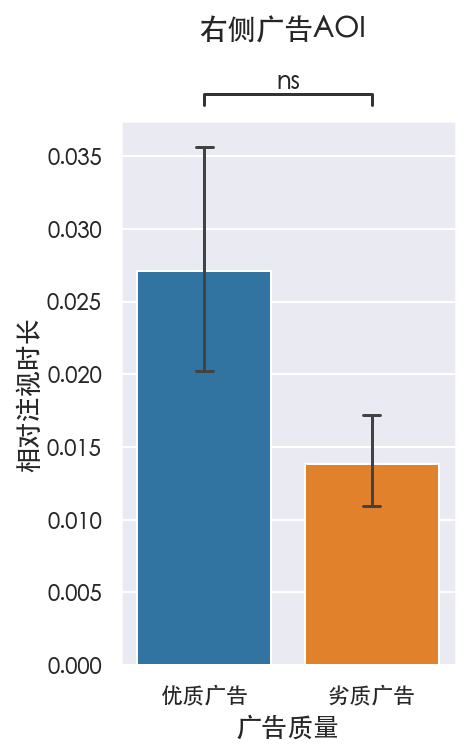

In [50]:
kw = plot_kw(quality_sum, 'ad_quality', [1,2])
fig, ax = plt.subplots(figsize=(3, 5))
ax = sns.barplot(**kw, ax=ax, capsize=.1, errwidth=1.5)
test_results = add_stat_annotation(ax, 
                                   **kw,
                                   **stat_anno_kw,
                                   box_pairs=[(1, 2)],
                                  )
_ = ax.set(
    ylabel=ylabel,
    xlabel="广告质量",
    xticklabels=["优质广告", "劣质广告"]
)

plt.suptitle("右侧广告AOI", y=1.03)

In [51]:
cutter = np.arange(0, len(data), 11)


records = []
for ix, n in enumerate(cutter):
    if ix < len(cutter) - 1:
        subdata = data.iloc[range(n, cutter[ix+1]), :].copy()
        assert subdata['ad_pos'].tolist() == list(range(1, 12))
        total_time = subdata.sum()['total']
        records.append([total_time, subdata['ad_quality'].unique()[0], subdata['ad_order'].unique()[0]])

quality_sum = pd.DataFrame(data=records, columns=['y', 'ad_quality', 'ad_order'])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.333e-02 U_stat=1.423e+05


Text(0.5, 1.03, '整体页面')

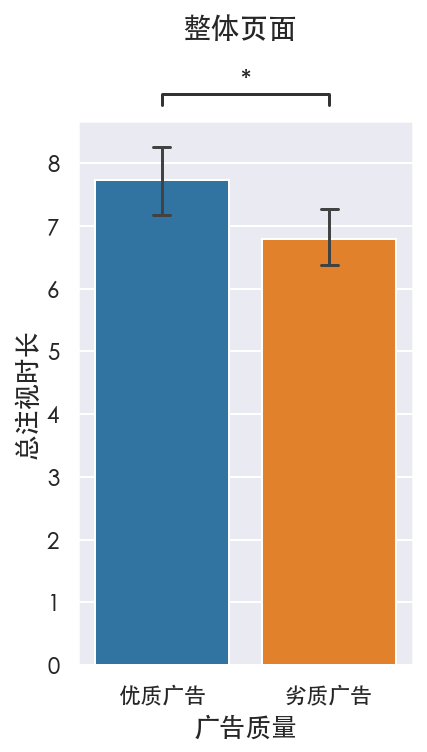

In [52]:
kw = plot_kw(quality_sum, 'ad_quality', [1,2])
fig, ax = plt.subplots(figsize=(3, 5))
ax = sns.barplot(**kw, ax=ax, capsize=.1, errwidth=1.5)
test_results = add_stat_annotation(ax, 
                                   **kw,
                                   **stat_anno_kw,
                                   box_pairs=[(1, 2)],
                                  )
_ = ax.set(
    ylabel="总注视时长",
    xlabel="广告质量",
    xticklabels=["优质广告", "劣质广告"]
)

plt.suptitle("整体页面", y=1.03)

### 广告优劣顺序

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2_1 v.s. 2_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.595e-15 U_stat=2.362e+04
1_1 v.s. 1_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.429e-15 U_stat=2.111e+04
3_1 v.s. 3_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.701e-05 U_stat=1.790e+04


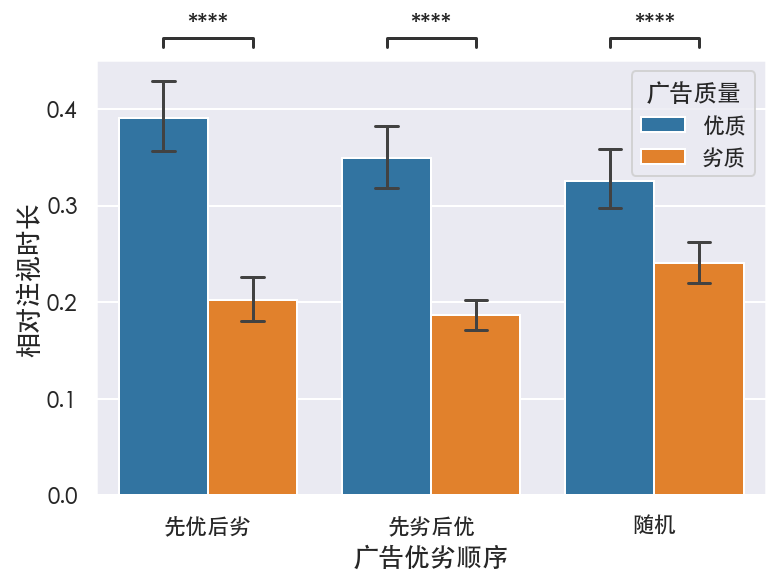

In [55]:
kw = dict(data=quality_sum[quality_sum['ad_order'].isin([1,2,3])], x='ad_order', y='y')
ax = sns.barplot(**kw, hue="ad_quality", capsize=.1, errwidth=1.5)


test_results = add_stat_annotation(ax, 
                                   **kw,
                                   **stat_anno_kw,
                                   hue="ad_quality",
                                   box_pairs=[((i,1), (i,2)) for i in range(1, 4)]
                                  )

leg = ax.get_legend()
leg.set_title("广告质量")
for l, t in zip(leg.texts, ["优质", "劣质"]):
    l.set_text(t)

_ = ax.set(
    ylabel=ylabel,
    xlabel="广告优劣顺序",
    xticklabels=["先优后劣", "先劣后优", "随机"]
)

### 利用梯度强化树(Gradient boosting tree)进行特征提取(feature selection)

此处利用微软的LightGBM对五种因素进行选择，选择在建立树分支中使用次数最多的特征，即为对输出影响最大对因素

First we need to encode the `y` into categorical data before processing

Check the distribution of `y`

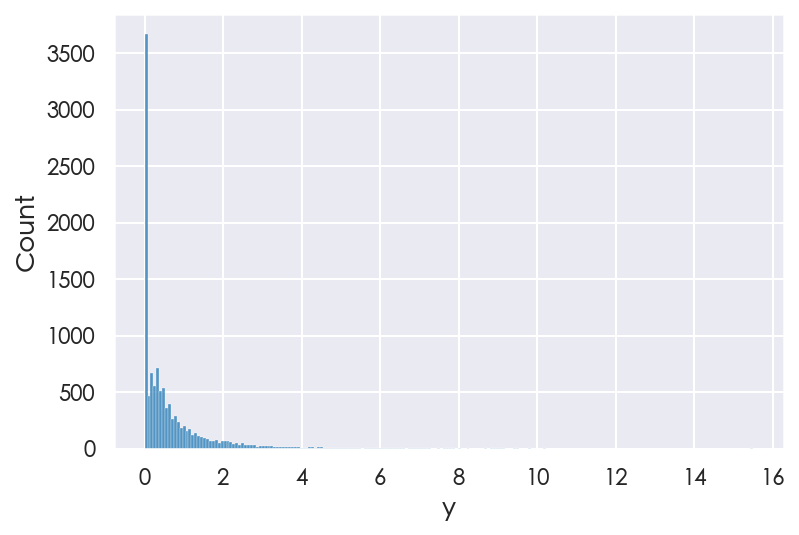

In [24]:
sns.histplot(data['y'])

In [25]:
X = data[['task_type', 'ad_order', 'ad_pos', 'ad_form', 'ad_quality']]
y = data['y']


Next, we need to encode y into categorical data

Divide into 3 category:
- 0: Deep attention: > 3s
- 1: Short attention: 1.5s ~ 3s
- 2: Not notice: < 1.5s

In [26]:
y = pd.cut(y.to_numpy(), [0, 0.5, 1, y.max()], right=True, include_lowest=True, labels=[0,1,2])

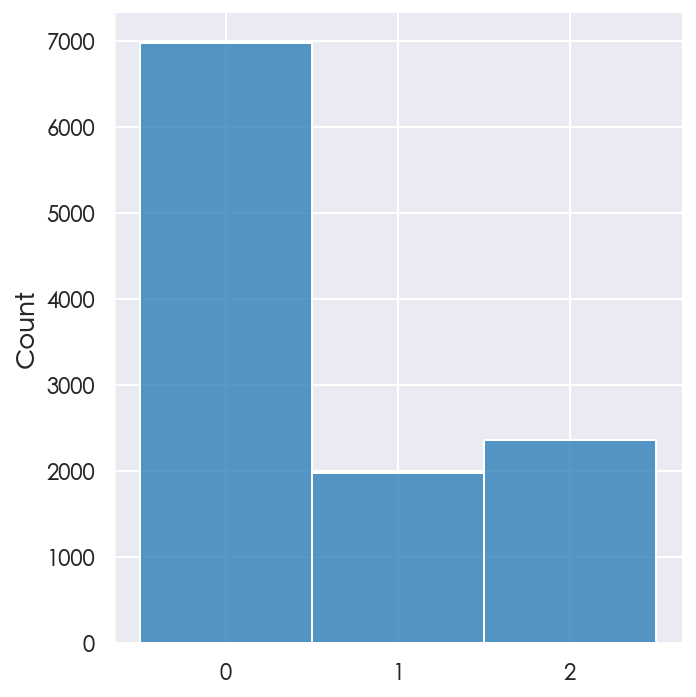

In [27]:
sns.displot([str(i) for i in sorted(y)])

Actually build the model, here we use the lightGBM

In [28]:
model = LGBMClassifier().fit(X, y, eval_metric="logloss")

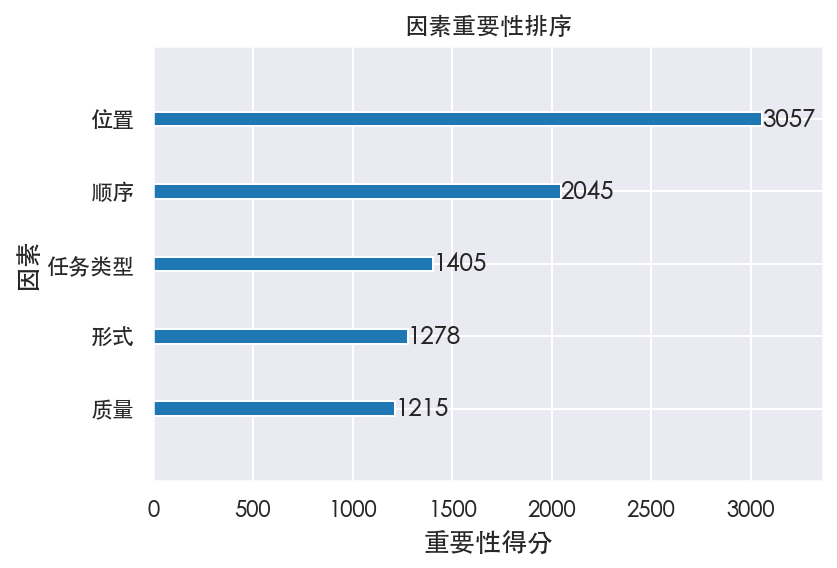

In [59]:
ax = lgb.plot_importance(model)
_ = ax.set(
    title="因素重要性排序",
    ylabel="因素",
    xlabel="重要性得分",
    yticklabels=['质量', '形式', '任务类型', '顺序', '位置']
)